## Install Packages

In [1]:
!conda install -y -c conda-forge faiss-gpu
!apt-get -y update
!apt-get -y install libatlas-base-dev

done
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.6.0.*, but conda is ignoring the .* and treating it as 1.6.0
WARNING conda.models.version:get_matcher(540): Using .* with relational operator is superfluous and deprecated and will be removed in a future version of conda. Your spec was 1.9.0.*, but conda is ignoring the .* and treating it as 1.9.0
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 25.7.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - faiss-gpu


The followin

## Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.random_projection import GaussianRandomProjection

from tqdm import tqdm

import faiss

In [3]:
df = pd.read_csv("../story_dataset.csv")
df

,prompt_id,prompt,story,hidden_state_file,len_generated_story,len_new_story
0,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Blaz...,./hidden_states/prompt_1.npz,270,271
1,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Spar...,./hidden_states/prompt_1.npz,349,350
2,1,Once upon a time there was a dragon,Once upon a time there was a dragon named Scor...,./hidden_states/prompt_1.npz,278,278
3,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,117,118
4,1,Once upon a time there was a dragon,Once upon a time there was a dragon. The drago...,./hidden_states/prompt_1.npz,129,130
...,...,...,...,...,...,...
9995,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,289,290
9996,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,119,119
9997,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,127,128
9998,10,Once upon a time there was a poor boy,Once upon a time there was a poor boy named Ti...,./hidden_states/prompt_10.npz,441,441


In [4]:
max_story_len = max(df["len_generated_story"])
max_story_len

522

In [5]:
hidden_states_by_layer = {}
NUM_PROMPTS = 10

for prompt_id in range(1, NUM_PROMPTS + 1):
    with np.load(f'../hidden_states/prompt_{prompt_id}.npz') as loaded_data:
        for i in tqdm(range(1000)):
            curr_hidden_states = loaded_data[f"arr_{i}"][0]
#             print(curr_hidden_states.shape)
            for layer in range(3, 4):
                padded_arr = np.zeros((max_story_len, 512))
                padded_arr_len = len(curr_hidden_states[layer][0])
                
                padded_arr[:padded_arr_len] = curr_hidden_states[layer][0]
                
                padded_arr = padded_arr.flatten().astype('float32') #FAISS expects data in type float32 instead of float64 - saves memory too!
#                 print(padded_arr.shape)
                
                if(f"layer_{layer}" in hidden_states_by_layer):
                    hidden_states_by_layer[f"layer_{layer}"].append(padded_arr)
                else:
                    hidden_states_by_layer[f"layer_{layer}"] = [padded_arr]

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:33<00:00, 10.71it/s]


In [6]:
layer_hs_array = np.array(hidden_states_by_layer["layer_3"])
layer_hs_array.shape

(10000, 267264)

## Layer 3 Clustering

In [7]:
# Use original vectors for clustering - uncomment next line and comment out last two lines

dim_reduced_vecs = layer_hs_array

# random_projector = GaussianRandomProjection(random_state = 42)
# dim_reduced_vecs = random_projector.fit_transform(layer_hs_array).astype('float32')

In [8]:
dim_reduced_vecs = np.array([v / np.linalg.norm(v) for v in dim_reduced_vecs])
dim_reduced_vecs.shape

(10000, 267264)

In [9]:
prompt_ids = df["prompt_id"]
prompt_ids = prompt_ids.to_numpy()
prompt_ids

array([ 1,  1,  1, ..., 10, 10, 10])

In [10]:
X_train = np.zeros((int(0.8 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_train = np.zeros(int(0.8 * dim_reduced_vecs.shape[0]))

X_test = np.zeros((int(0.2 * dim_reduced_vecs.shape[0]), dim_reduced_vecs.shape[1]), dtype = np.float32)
y_test = np.zeros(int(0.2 * dim_reduced_vecs.shape[0]))

In [11]:
for i in range(10):
    X_train[i * 800 : (i + 1) * 800] = dim_reduced_vecs[i * 1000 : (i * 1000) + 800]
    y_train[i * 800 : (i + 1) * 800] = prompt_ids[i * 1000 : (i * 1000) + 800]
    
    X_test[i * 200 : (i + 1) * 200] = dim_reduced_vecs[(i * 1000) + 800 : (i + 1) * 1000]
    y_test[i * 200 : (i + 1) * 200] = prompt_ids[(i * 1000) + 800 : (i + 1) * 1000]

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 267264)
(8000,)
(2000, 267264)
(2000,)


Sampling a subset of 4000 / 8000 for training
Clustering 4000 points in 267264D to 5 clusters, redo 10 times, 20 iterations
  Preprocessing in 3.65 s
Outer iteration 0 / 10
  Iteration 19 (11.23 s, search 7.53 s): objective=1942.63 imbalance=1.094 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (22.45 s, search 15.05 s): objective=1942.8 imbalance=1.120 nsplit=0        
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (33.75 s, search 22.60 s): objective=1936.9 imbalance=1.035 nsplit=0        
Outer iteration 3 / 10
  Iteration 19 (44.97 s, search 30.12 s): objective=1937.2 imbalance=1.092 nsplit=0        
Outer iteration 4 / 10
  Iteration 19 (56.18 s, search 37.63 s): objective=1941.68 imbalance=1.087 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (68.12 s, search 45.40 s): objective=1936.08 imbalance=1.109 nsplit=0       
Outer iteration 6 / 10
  Iteration 19 (79.80 s, search 53.18 s): objective=1927.18 im

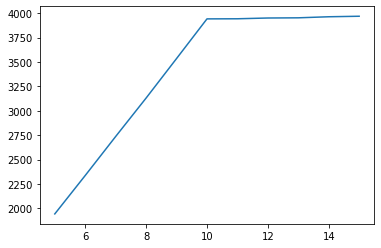

In [13]:
# Elbow Plot
niter = 20
verbose = True
dim = X_train.shape[1]

k_vals = [k for k in range(5, 16)]
wccs = []
for k in k_vals:
    kmeans = faiss.Kmeans(dim, k, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
    kmeans.train(X_train)
    wccs.append(kmeans.obj[-1])

plt.plot(k_vals, wccs)

In [14]:
# K-means Clustering

# ncentroids = NUM_PROMPTS
ncentroids = 10 # Elbow point - based on objective (sum of cosine similarities)
niter = 20
verbose = True
dim = X_train.shape[1]
kmeans = faiss.Kmeans(dim, ncentroids, niter = niter, verbose = verbose, gpu = True, nredo = 10, spherical = True, max_points_per_centroid = 800)
kmeans.train(X_train)


Clustering 8000 points in 267264D to 10 clusters, redo 10 times, 20 iterations
  Preprocessing in 1.13 s
Outer iteration 0 / 10
  Iteration 19 (24.22 s, search 15.83 s): objective=3909.97 imbalance=1.825 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 10
  Iteration 19 (49.22 s, search 32.24 s): objective=3926.33 imbalance=1.137 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 10
  Iteration 19 (72.51 s, search 47.77 s): objective=3910.93 imbalance=1.594 nsplit=0       
Outer iteration 3 / 10
  Iteration 19 (95.08 s, search 62.87 s): objective=3921.5 imbalance=1.144 nsplit=0        
Outer iteration 4 / 10
  Iteration 19 (117.69 s, search 77.94 s): objective=3902.38 imbalance=2.157 nsplit=0       
Outer iteration 5 / 10
  Iteration 19 (140.34 s, search 93.09 s): objective=3936.1 imbalance=1.168 nsplit=0        
Objective improved: keep new clusters
Outer iteration 6 / 10
  Iteration 19 (162.96 s, search 108.20 s): objective=3930.24 imb

3941.995849609375

In [15]:
kmeans.centroids #cluster centers

array([[ 3.9564660e-03,  1.3734432e-03,  1.0179476e-02, ...,
        -9.9493843e-07,  1.3232846e-06,  3.4375346e-06],
       [ 4.4843750e-03,  1.5567022e-03,  1.1537718e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 3.8073631e-03,  1.3216824e-03,  9.7958539e-03, ...,
        -2.3013863e-06, -5.9755757e-07, -2.0793714e-06],
       ...,
       [ 4.0952186e-03,  1.4216126e-03,  1.0536477e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 3.8270249e-03,  1.3285097e-03,  9.8464461e-03, ...,
        -3.6758247e-05,  1.4072597e-06,  2.4572581e-05],
       [ 4.3779956e-03,  1.5197742e-03,  1.1264019e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [16]:
for centroid in kmeans.centroids:
    print(np.linalg.norm(centroid))

1.0000328
1.0000116
1.0000265
1.0000083
1.0000234
1.0000138
1.0000188
1.0000561
1.000029
1.0000787


In [17]:
kmeans.obj #inertia at each iteration

array([2543.39648438, 3777.36035156, 3844.76489258, 3873.64624023,
       3886.29931641, 3893.71142578, 3897.71606445, 3899.32666016,
       3900.16796875, 3901.00854492, 3902.31518555, 3903.97680664,
       3906.01855469, 3907.69970703, 3908.87353516, 3909.52783203,
       3909.85229492, 3909.93481445, 3909.95703125, 3909.96826172,
       2595.61938477, 3795.13989258, 3829.18408203, 3857.1953125 ,
       3882.04174805, 3904.94238281, 3915.52734375, 3919.96557617,
       3921.98706055, 3923.15625   , 3924.20703125, 3925.01367188,
       3925.51464844, 3925.7824707 , 3925.97485352, 3926.09423828,
       3926.17822266, 3926.24121094, 3926.29931641, 3926.33496094,
       2488.80200195, 3779.22412109, 3822.20141602, 3857.33642578,
       3871.45703125, 3879.59570312, 3888.95800781, 3899.68945312,
       3905.14306641, 3907.77294922, 3908.91625977, 3909.42480469,
       3909.78833008, 3910.02368164, 3910.24560547, 3910.50683594,
       3910.64013672, 3910.77124023, 3910.85717773, 3910.93310

In [18]:
cos_similarities = X_train @ kmeans.centroids.T
classifications_train = np.argmax(cos_similarities, axis=1)

In [19]:
pd.Series(classifications_train).value_counts()

7    1107
0    1086
1    1015
5     972
3     956
4     942
2     601
9     524
8     446
6     351
dtype: int64

In [20]:
# Get most common label for each point classified to a centroid (same centroid)
centroid_labels = [np.where(classifications_train == i)[0] for i in range(ncentroids)]
max_label_per_centroid = [int(pd.Series(y_train[centroid_labels[i]]).value_counts().idxmax()) for i in range(ncentroids)]
max_label_per_centroid

[5, 1, 9, 5, 6, 6, 10, 6, 10, 3]

In [21]:
centroid_to_label = {idx : max_label_per_centroid[idx] for idx in range(len(max_label_per_centroid))}

In [22]:
centroid_to_label

{0: 5, 1: 1, 2: 9, 3: 5, 4: 6, 5: 6, 6: 10, 7: 6, 8: 10, 9: 3}

In [23]:
vectorized_map = np.vectorize(centroid_to_label.get)
classifications_to_label = vectorized_map(classifications_train)

classifications_to_label

array([ 5,  9,  9, ..., 10, 10, 10])

In [24]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label[i * 800:(i + 1) * 800] == (i + 1)))

Prompt 1 Accuracy:  0.2975
Prompt 2 Accuracy:  0.0
Prompt 3 Accuracy:  0.6475
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.925
Prompt 6 Accuracy:  0.7725
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.235
Prompt 10 Accuracy:  0.975


In [25]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label == y_train))

Overall Accuracy:  0.38525


## Perform Inference on Test Set & Collect Test Accuracy

In [26]:
cos_similarities = X_test @ kmeans.centroids.T
classifications_test = np.argmax(cos_similarities, axis=1)

In [27]:
pd.Series(classifications_test).value_counts()

1    271
7    266
0    257
3    245
4    236
5    229
2    158
9    135
8    120
6     83
dtype: int64

In [28]:
classifications_to_label_test = vectorized_map(classifications_test)

classifications_to_label_test

array([ 1,  9,  5, ..., 10, 10, 10])

In [29]:
for i in range(10):
    print(f"Prompt {i + 1} Accuracy: ", np.mean(classifications_to_label_test[i * 200:(i + 1) * 200] == (i + 1)))

Prompt 1 Accuracy:  0.31
Prompt 2 Accuracy:  0.0
Prompt 3 Accuracy:  0.665
Prompt 4 Accuracy:  0.0
Prompt 5 Accuracy:  0.935
Prompt 6 Accuracy:  0.785
Prompt 7 Accuracy:  0.0
Prompt 8 Accuracy:  0.0
Prompt 9 Accuracy:  0.28
Prompt 10 Accuracy:  0.99


In [30]:
print(f"Overall Accuracy: ", np.mean(classifications_to_label_test == y_test))

Overall Accuracy:  0.3965


## Confusion Matrix of Results

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

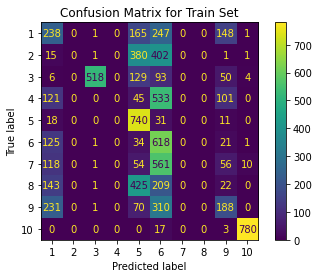

In [32]:
cm = confusion_matrix(y_train, classifications_to_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

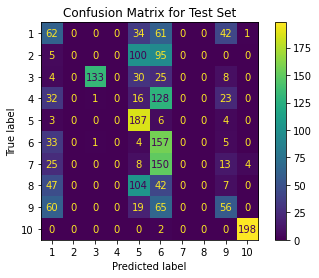

In [33]:
cm = confusion_matrix(y_test, classifications_to_label_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f"{i}" for i in range(1, 11)])

disp.plot()
plt.title('Confusion Matrix for Test Set')
plt.show()